In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing Datasets

In [3]:
#Create list for the header
columns = ['age', 'sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 
                 'sick', 'pregnant', 'thyroid_surgery', 'I131 treatment', 'query hypothyroid', 
                 'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 
                 'TSH measured', 'TSH', 'T3 measured', 'T3', 'TT4 measured', 'TT4', 'T4U measured', 
                 'T4U', 'FTI measured', 'FTI', 'TBG measured', 'TBG', 'referral source', 'result']

In [4]:
#Function to clean up result column
def sep_result(text):
    return text.split('.')[0]

In [5]:
#Function to read in datasets
def read_data(df_name, columns, name):
    df = pd.read_csv("thyroid+disease/" + df_name, header=None, names=columns)
    df['result_clean_' + name] = df['result'].apply(sep_result)
    df = df.drop(columns='result')
    return df

In [6]:
#Read in training sets
allbp = read_data("allbp.data", columns, 'allbp')
allhyper = read_data("allhyper.data", columns, 'allhyper')
allhypo = read_data("allhypo.data", columns, 'allhypo')
allrep = read_data("allrep.data", columns, 'allrep')
dis = read_data("dis.data", columns, 'dis')
sick = read_data("sick.data", columns, 'sick')

In [7]:
#Read in testing sets
allbp_test = read_data("allbp.test", columns, 'allbp')
allhyper_test = read_data("allhyper.test", columns, 'allhyper')
allhypo_test = read_data("allhypo.test", columns, 'allhypo')
allrep_test = read_data("allrep.test", columns, 'allrep')
dis_test = read_data("dis.test", columns, 'dis')
sick_test = read_data("sick.test", columns, 'sick')

In [8]:
#Combine testing and training into one dataset for cleaning
allbp = pd.concat([allbp, allbp_test])
allhyper = pd.concat([allhyper, allhyper_test])
allhypo = pd.concat([allhypo, allhypo_test])
allrep = pd.concat([allrep, allrep_test])
dis = pd.concat([dis, dis_test])
sick = pd.concat([sick, sick_test])

# Data Cleaning

## Cleanup/Combine Results

In [9]:
#Combine results from all datasets into one
columns_to_add = pd.DataFrame({
    'result_clean_allhyper' : allhyper['result_clean_allhyper'], 
    'result_clean_allhypo' : allhypo['result_clean_allhypo'], 
    'result_clean_allrep' : allrep['result_clean_allrep'], 
    'result_clean_dis' : dis['result_clean_dis'], 
    'result_clean_sick' : sick['result_clean_sick']})

# Concatenate the columns to df_target
combined = pd.concat([allbp, columns_to_add], axis=1)

In [10]:
#Create one more result column including all abnormalities
columns_to_check =['result_clean_allbp','result_clean_allhyper', 'result_clean_allhypo', 'result_clean_allrep', 
                   'result_clean_dis', 'result_clean_sick']

def check_row(row, cols):
    if all(row[cols] == 'negative'):
        return 'negative'
    else:
        return 'abnormal'

# Apply the function to each row, passing the subset of columns
combined['result_any'] = combined.apply(lambda row: check_row(row, columns_to_check), axis=1)

In [11]:
#Check for % NaN
(combined == '?').mean() * 100

age                            0.026511
sex                            3.976670
on_thyroxine                   0.000000
query_on_thyroxine             0.000000
on_antithyroid_medication      0.000000
sick                           0.000000
pregnant                       0.000000
thyroid_surgery                0.000000
I131 treatment                 0.000000
query hypothyroid              0.000000
query hyperthyroid             0.000000
lithium                        0.000000
goitre                         0.000000
tumor                          0.000000
hypopituitary                  0.000000
psych                          0.000000
TSH measured                   0.000000
TSH                            9.782609
T3 measured                    0.000000
T3                            20.387063
TT4 measured                   0.000000
TT4                            6.124072
T4U measured                   0.000000
T4U                           10.259809
FTI measured                   0.000000


Drop TBG because it is completely empty. Impute Age, TSH, T3, TT4, T4U and FTI with mean and median since NaN percentage is <= 50%. Remove rows with NaN for sex unless analysis shows that it is not an important parameter for classifcation.

In [12]:
#Remove TBG and TBG measured
combined = combined.drop(columns= ['TBG measured', 'TBG'])

In [13]:
combined.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131 treatment,query hypothyroid,...,FTI measured,FTI,referral source,result_clean_allbp,result_clean_allhyper,result_clean_allhypo,result_clean_allrep,result_clean_dis,result_clean_sick,result_any
0,41,F,f,f,f,f,f,f,f,f,...,t,109,SVHC,negative,negative,negative,negative,negative,negative,negative
1,23,F,f,f,f,f,f,f,f,f,...,f,?,other,negative,negative,negative,negative,negative,negative,negative
2,46,M,f,f,f,f,f,f,f,f,...,t,120,other,negative,negative,negative,negative,negative,negative,negative
3,70,F,t,f,f,f,f,f,f,f,...,f,?,other,negative,negative,negative,replacement therapy,negative,negative,abnormal
4,70,F,f,f,f,f,f,f,f,f,...,t,70,SVI,negative,negative,negative,negative,negative,negative,negative


In [14]:
#Convert column values to numeric
num_cols = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']

for col in num_cols:
    combined[col] = pd.to_numeric(combined[col], errors='coerce')

In [15]:
combined.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131 treatment,query hypothyroid,...,FTI measured,FTI,referral source,result_clean_allbp,result_clean_allhyper,result_clean_allhypo,result_clean_allrep,result_clean_dis,result_clean_sick,result_any
0,41.0,F,f,f,f,f,f,f,f,f,...,t,109.0,SVHC,negative,negative,negative,negative,negative,negative,negative
1,23.0,F,f,f,f,f,f,f,f,f,...,f,NaN,other,negative,negative,negative,negative,negative,negative,negative
2,46.0,M,f,f,f,f,f,f,f,f,...,t,120.0,other,negative,negative,negative,negative,negative,negative,negative
3,70.0,F,t,f,f,f,f,f,f,f,...,f,NaN,other,negative,negative,negative,replacement therapy,negative,negative,abnormal
4,70.0,F,f,f,f,f,f,f,f,f,...,t,70.0,SVI,negative,negative,negative,negative,negative,negative,negative


In [16]:
combined.isna().mean() * 100

age                           0.026511
sex                           0.000000
on_thyroxine                  0.000000
query_on_thyroxine            0.000000
on_antithyroid_medication     0.000000
sick                          0.000000
pregnant                      0.000000
thyroid_surgery               0.000000
I131 treatment                0.000000
query hypothyroid             0.000000
query hyperthyroid            0.000000
lithium                       0.000000
goitre                        0.000000
tumor                         0.000000
hypopituitary                 0.000000
psych                         0.000000
TSH measured                  0.000000
TSH                           9.782609
T3 measured                   0.000000
T3                           20.387063
TT4 measured                  0.000000
TT4                           6.124072
T4U measured                  0.000000
T4U                          10.259809
FTI measured                  0.000000
FTI                      

In [17]:
#Got rid of outliers in age
combined[combined['age'] >= 90]

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131 treatment,query hypothyroid,...,FTI measured,FTI,referral source,result_clean_allbp,result_clean_allhyper,result_clean_allhypo,result_clean_allrep,result_clean_dis,result_clean_sick,result_any
440,90.0,F,f,t,f,f,f,f,f,f,...,t,224.0,SVI,negative,negative,negative,negative,negative,negative,negative
556,90.0,F,f,f,f,f,f,f,f,f,...,t,69.0,other,negative,negative,negative,negative,negative,negative,negative
1129,94.0,F,f,f,f,f,f,f,f,f,...,t,154.0,SVI,negative,negative,negative,negative,negative,negative,negative
1364,455.0,F,f,f,f,f,f,f,f,f,...,t,104.0,SVI,negative,negative,negative,negative,negative,negative,negative
1403,90.0,M,f,f,f,f,f,f,f,f,...,t,144.0,SVI,negative,negative,negative,negative,negative,negative,negative
1490,91.0,M,f,f,f,f,f,f,f,f,...,t,113.0,SVI,negative,negative,negative,negative,negative,negative,negative
1558,90.0,F,f,f,f,f,f,f,f,f,...,t,104.0,SVI,negative,negative,negative,negative,negative,negative,negative
1727,91.0,F,f,f,f,f,f,f,f,f,...,t,132.0,SVI,negative,negative,negative,negative,negative,negative,negative
2244,90.0,M,f,f,f,f,f,f,f,f,...,t,98.0,other,negative,negative,negative,negative,negative,negative,negative
2418,93.0,F,f,f,f,t,f,f,f,f,...,t,90.0,other,negative,negative,negative,negative,negative,sick,abnormal


In [18]:
combined = combined.drop(1364)

In [19]:
combined[combined['age'] >= 90]

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131 treatment,query hypothyroid,...,FTI measured,FTI,referral source,result_clean_allbp,result_clean_allhyper,result_clean_allhypo,result_clean_allrep,result_clean_dis,result_clean_sick,result_any
440,90.0,F,f,t,f,f,f,f,f,f,...,t,224.0,SVI,negative,negative,negative,negative,negative,negative,negative
556,90.0,F,f,f,f,f,f,f,f,f,...,t,69.0,other,negative,negative,negative,negative,negative,negative,negative
1129,94.0,F,f,f,f,f,f,f,f,f,...,t,154.0,SVI,negative,negative,negative,negative,negative,negative,negative
1403,90.0,M,f,f,f,f,f,f,f,f,...,t,144.0,SVI,negative,negative,negative,negative,negative,negative,negative
1490,91.0,M,f,f,f,f,f,f,f,f,...,t,113.0,SVI,negative,negative,negative,negative,negative,negative,negative
1558,90.0,F,f,f,f,f,f,f,f,f,...,t,104.0,SVI,negative,negative,negative,negative,negative,negative,negative
1727,91.0,F,f,f,f,f,f,f,f,f,...,t,132.0,SVI,negative,negative,negative,negative,negative,negative,negative
2244,90.0,M,f,f,f,f,f,f,f,f,...,t,98.0,other,negative,negative,negative,negative,negative,negative,negative
2418,93.0,F,f,f,f,t,f,f,f,f,...,t,90.0,other,negative,negative,negative,negative,negative,sick,abnormal
2673,94.0,M,f,f,f,f,f,f,f,f,...,t,114.0,SVI,negative,negative,negative,negative,negative,negative,negative


#### TSH Normal Ranges
- TSH normal values are 0.5 to 5.0 mIU/L. 
- The range for normal values are: Total T3 -- 60 to 180 nanograms per deciliter (ng/dL), or 0.9 to 2.8 nanomoles per liter (nmol/L)
- A normal Total T4 level in adults ranges from 5.0 to 12.0μg/dL.
- Thyroxine-binding globulin concentration in normal adult human serum ranges from 12 to 20 mg/L
- The normal range for the free T index is 4.8 to 12.7 mcg/dL.

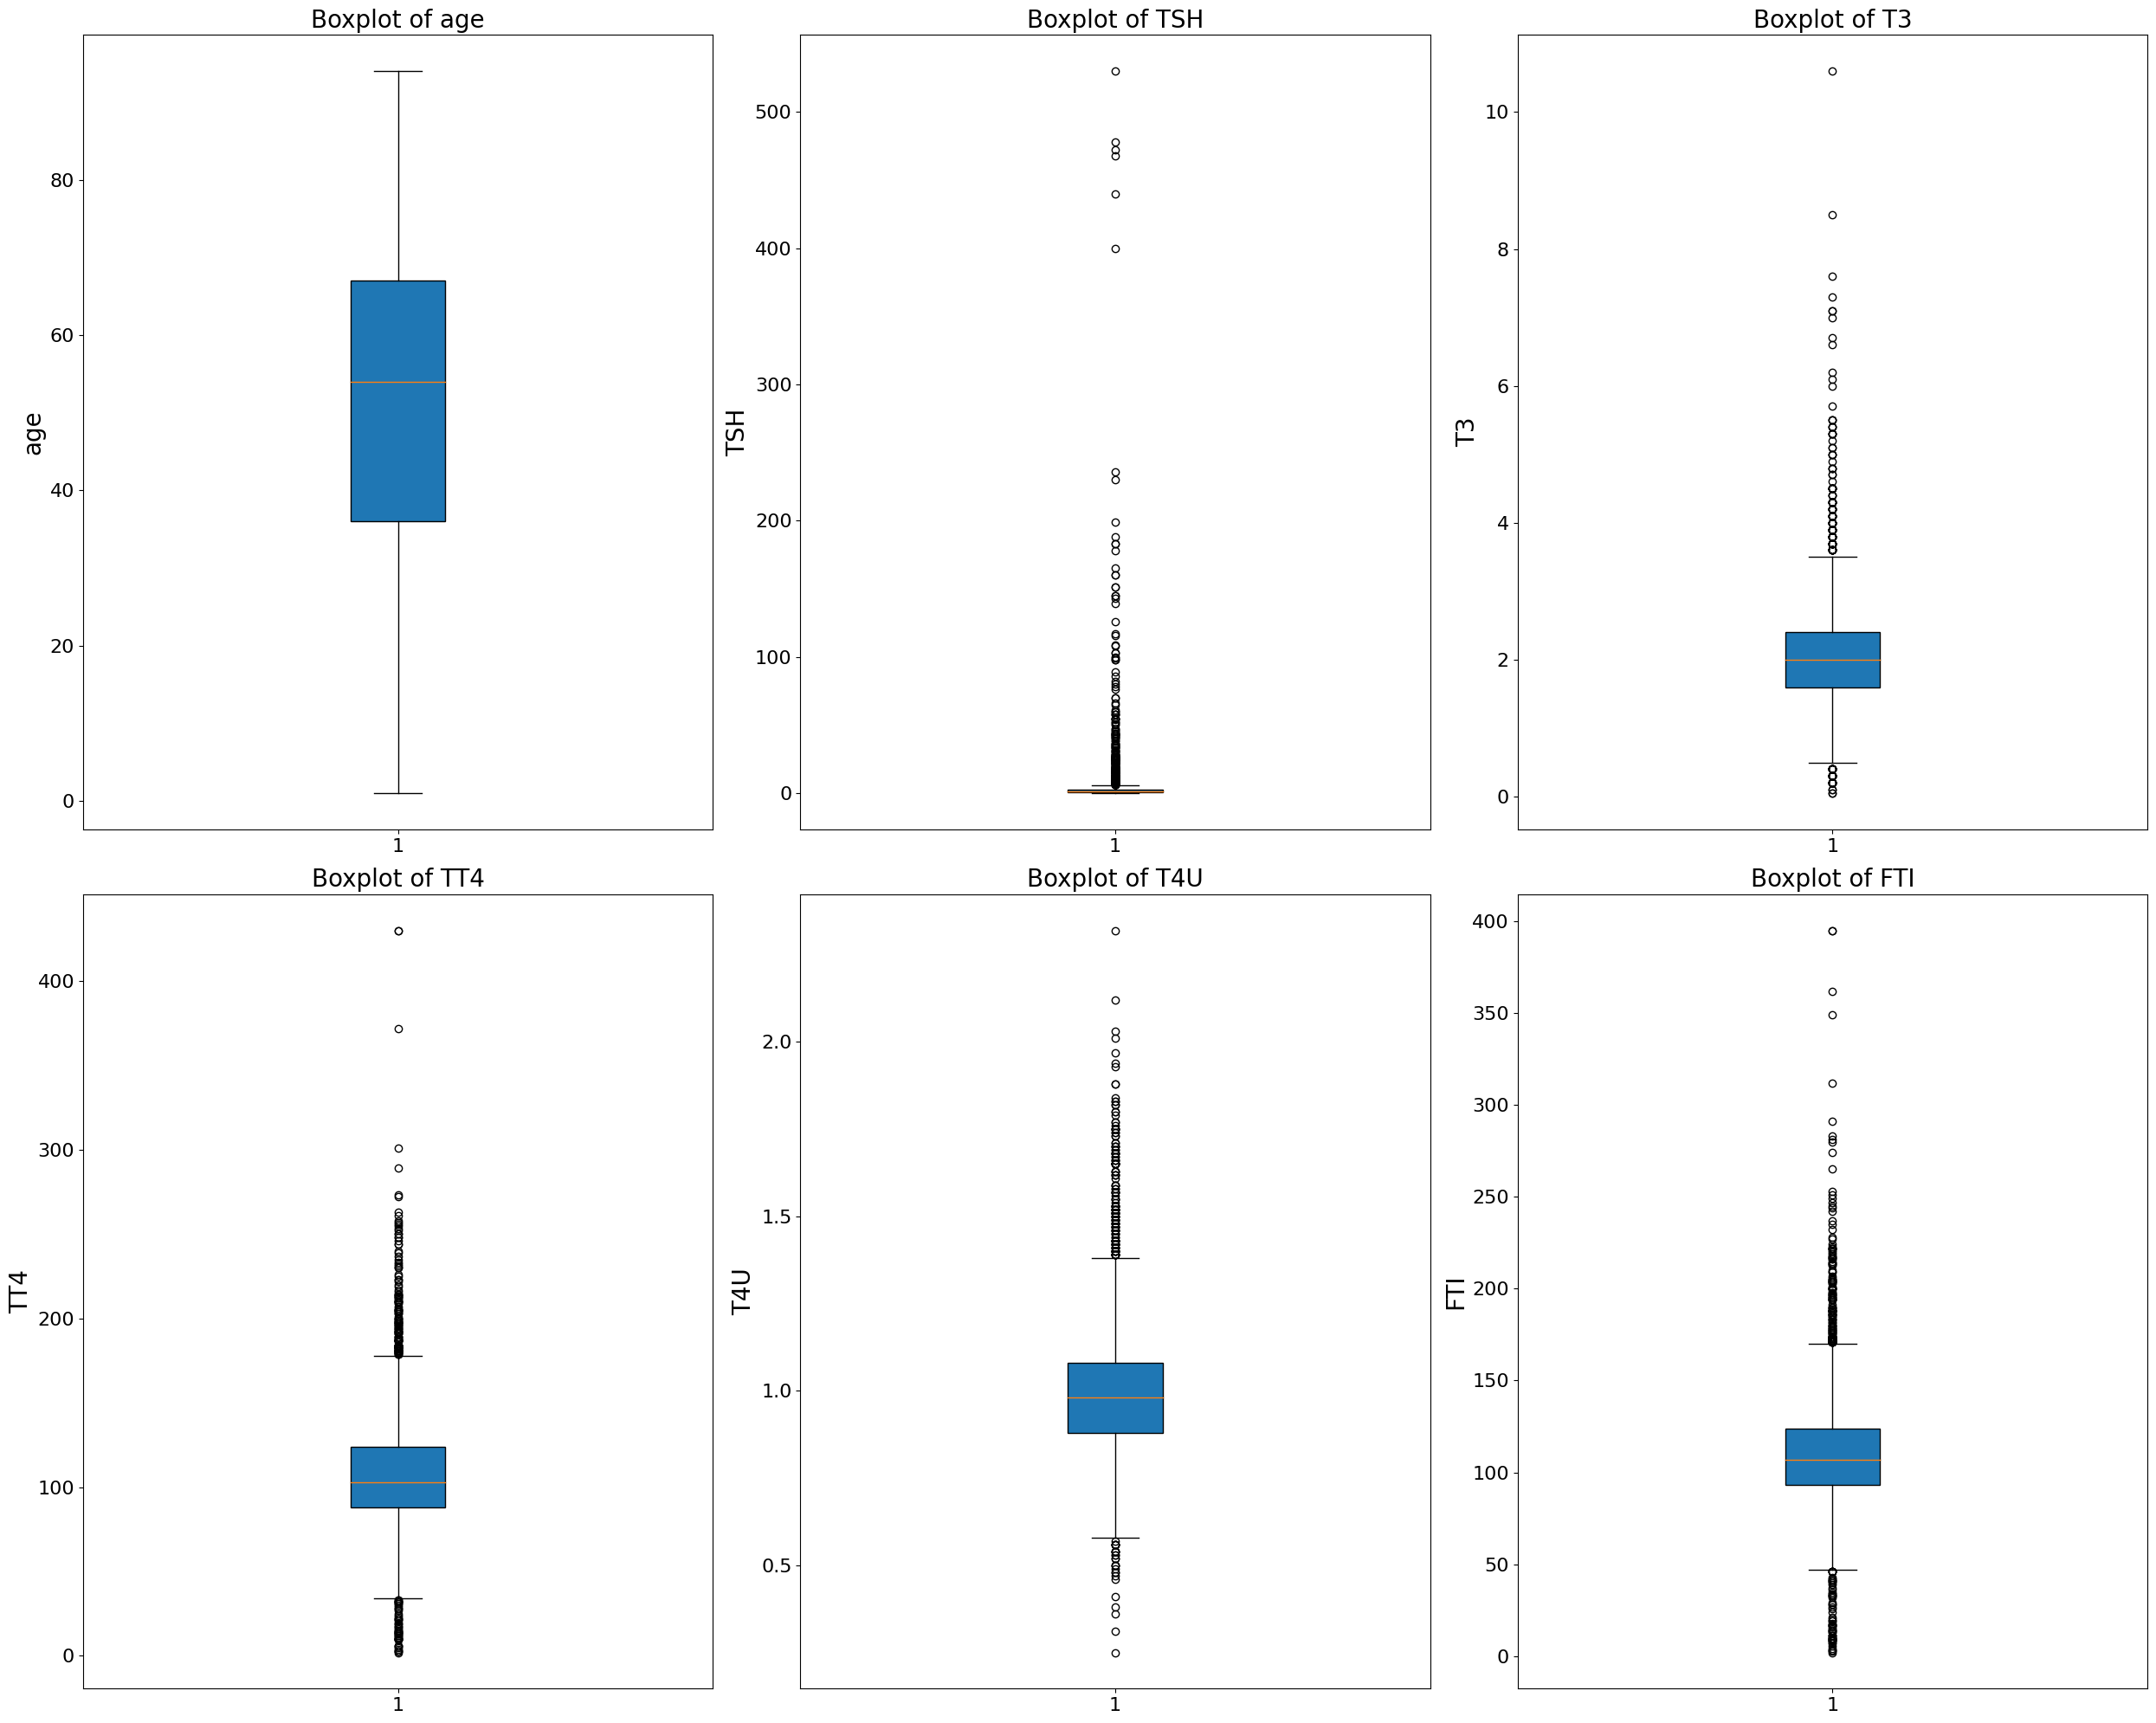

In [20]:
#Plot box plots of different features to find outliers
combined_cleaned = [combined[col].dropna() for col in num_cols]

fig, axs = plt.subplots(2, 3, figsize=(25, 20))

axs = axs.flatten()


for ax, data, col in zip(axs, combined_cleaned, num_cols):
    ax.boxplot(data, patch_artist=True)
    ax.set_title(f'Boxplot of {col}', fontsize=20)
    ax.set_ylabel(col, fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)
        
    
plt.tight_layout()

plt.show()

In [21]:
#Remove likely errors
print(combined[combined['TSH'] >= 350].index)
print(combined[combined['T3'] >= 10].index)
print(combined[combined['TT4'] >= 350].index)

Int64Index([1165, 2507, 2772, 627, 649, 839], dtype='int64')
Int64Index([1671], dtype='int64')
Int64Index([743, 1415, 458], dtype='int64')


In [22]:
combined = combined.drop([1165, 2507, 2772, 627, 649, 839, 1671, 743, 1415, 458])

In [23]:
mean_val = combined['TSH'].mean()

In [24]:
#Impute columns with mean
impute_cols = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']

for col in impute_cols:
    mean_val = combined[col].mean()
    combined.fillna(value=mean_val, inplace=True)

In [25]:
combined.isna().mean() * 100

age                          0.0
sex                          0.0
on_thyroxine                 0.0
query_on_thyroxine           0.0
on_antithyroid_medication    0.0
sick                         0.0
pregnant                     0.0
thyroid_surgery              0.0
I131 treatment               0.0
query hypothyroid            0.0
query hyperthyroid           0.0
lithium                      0.0
goitre                       0.0
tumor                        0.0
hypopituitary                0.0
psych                        0.0
TSH measured                 0.0
TSH                          0.0
T3 measured                  0.0
T3                           0.0
TT4 measured                 0.0
TT4                          0.0
T4U measured                 0.0
T4U                          0.0
FTI measured                 0.0
FTI                          0.0
referral source              0.0
result_clean_allbp           0.0
result_clean_allhyper        0.0
result_clean_allhypo         0.0
result_cle

In [26]:
bool_cols = ['on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 
                 'sick', 'pregnant', 'thyroid_surgery', 'I131 treatment', 'query hypothyroid', 
                 'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 
                 'TSH measured', 'T3 measured', 'TT4 measured', 'T4U measured', 
                 'FTI measured',]

In [27]:
#convert t and f to 1 and 0
for col in bool_cols:
    combined[col] = combined[col].apply(lambda x: 1 if x == 't' else 0)

In [28]:
combined['sex'] = combined['sex'].apply(lambda x: 1 if x == 'F' else 0)

In [29]:
combined.dtypes

age                          float64
sex                            int64
on_thyroxine                   int64
query_on_thyroxine             int64
on_antithyroid_medication      int64
sick                           int64
pregnant                       int64
thyroid_surgery                int64
I131 treatment                 int64
query hypothyroid              int64
query hyperthyroid             int64
lithium                        int64
goitre                         int64
tumor                          int64
hypopituitary                  int64
psych                          int64
TSH measured                   int64
TSH                          float64
T3 measured                    int64
T3                           float64
TT4 measured                   int64
TT4                          float64
T4U measured                   int64
T4U                          float64
FTI measured                   int64
FTI                          float64
referral source               object
r

In [30]:
combined = combined.drop(columns='referral source')

In [31]:
combined.dtypes

age                          float64
sex                            int64
on_thyroxine                   int64
query_on_thyroxine             int64
on_antithyroid_medication      int64
sick                           int64
pregnant                       int64
thyroid_surgery                int64
I131 treatment                 int64
query hypothyroid              int64
query hyperthyroid             int64
lithium                        int64
goitre                         int64
tumor                          int64
hypopituitary                  int64
psych                          int64
TSH measured                   int64
TSH                          float64
T3 measured                    int64
T3                           float64
TT4 measured                   int64
TT4                          float64
T4U measured                   int64
T4U                          float64
FTI measured                   int64
FTI                          float64
result_clean_allbp            object
r

## Logisitic Regression Model Preperation

In [32]:
def scale(df, result):
    df_X = df.drop(columns=result)
    df_Y = df[result]

    df_X = df_X.reset_index(drop=True)
    df_Y = df_Y.reset_index(drop=True)

    df_X = (df_X - df_X.mean()) / df_X.std()

    X_train = df_X.loc[:(2*(len(df)))/3]
    Y_train = df_Y.loc[:(2*(len(df)))/3]

    X_test = df_X.loc[(((2*(len(df)))/3) + 1):]
    Y_test = df_Y.loc[(((2*(len(df)))/3) + 1):]
    
    X_train['constant'] = 1
    X_test['constant'] = 1
    
    return X_train, X_test, Y_train, Y_test

In [33]:
class LogReg:
    
    def __init__(self, X_train, X_test, Y_train, Y_test, alpha):
        self.X_train = X_train
        self.X_test = X_test
        self.Y_train = Y_train
        self.Y_test = Y_test
        self.alpha = alpha
        self.theta = np.random.randn(len(self.X_train.columns)) * 0.01
            
    def sigmoid(self, prediction):    
        if prediction >= 0.5:
            return 1
        else:
            return 0
        
    def sigmoid_list(self, predictions):
        answers = []
        for prediction in predictions:
            if prediction >= 0.5:
                answers.append(1)
            else:
                answers.append(0)
        return answers
        
    def train(self):
        prev_accuracy = 0
        for k in range(1000):
            for i in range(0, len(self.X_train)):
                    h = 1/(1 + np.exp(-(np.dot(self.X_train.loc[i],self.theta))))
                    h_ = self.sigmoid(h)
                    for j in range(0, len(self.X_train.columns)):
                        self.theta[j] = self.theta[j] + self.alpha*(self.Y_train[i] - h_)*self.X_train.loc[i][j]

            h = 1/(1 + np.exp(-(np.dot(self.X_test, self.theta))))
            h_ = self.sigmoid_list(h)
            correct_predictions = (h_ == self.Y_test)
            accuracy = correct_predictions.sum()/len(self.Y_test)

            if (np.abs(accuracy - prev_accuracy) <= 0.00001):
                break

            prev_accuracy = accuracy
            
        return self.theta

In [34]:
class MultLogReg:
    
    def __init__(self, X_train, X_test, Y_train, Y_test, class_name):
        self.X_train = X_train
        self.X_test = X_test
        self.Y_train = Y_train
        self.Y_test = Y_test
        self.class_name = class_name
        self.classes = self.Y_train.unique()
        self.numClasses = len(self.classes)
        
    def confidence(self, x, model):
        return 1/(1 + np.exp(-(np.dot(x, model))))
    
    def log_reg_models(self):
        
        models = []
        
        for j in range(0, self.numClasses):
            
            mapping = {}
        
            for i in range(0, self.numClasses):
                if (i == j):
                    mapping[self.classes[i]] = 1
                else:
                    mapping[self.classes[i]] = 0

            Y_train_copy = self.Y_train.copy()
            Y_test_copy = self.Y_test.copy()

            Y_train_copy = Y_train_copy.apply(lambda x: mapping[x])
            Y_test_copy = Y_test_copy.apply(lambda x: mapping[x])

            logreg = LogReg(self.X_train, self.X_test, Y_train_copy, Y_test_copy, 0.00001)
            
            model = logreg.train()
            
            models.append(model)
        return models
    
    
    def multi_log_reg_model(self, models):
        mapping = {}
        
        for i in range(0, self.numClasses):
            mapping[self.classes[i]] = i
            
        Y_test_copy = self.Y_test.copy()

        Y_test_copy = Y_test_copy.apply(lambda x: mapping[x])
               
        correct = 0

        X_test = self.X_test.reset_index(drop=True)
        Y_test_copy = Y_test_copy.reset_index(drop=True)
        
        class_amounts = {}
        
        for i in range(0, self.numClasses):
            class_amounts[i] = [0, 0]
            for j in range(0, len(Y_test_copy)):
                if Y_test_copy.loc[j] == i:
                    class_amounts[i][1] += 1 
        
        for i in range(0, len(X_test)):  
            model_scores = {}

            for j, model in enumerate(models, 0):
                model_scores[j] = self.confidence(X_test.loc[i], model)

            if (max(model_scores, key=model_scores.get) == Y_test_copy.loc[i]):
                correct += 1
                class_amounts[Y_test_copy.loc[i]][0] += 1
        
        accuracy = correct/len(Y_test_copy)
        
        class_accuracies = {}
        for i in range(0, self.numClasses):
            class_accuracies[self.classes[i]] = class_amounts[i][0]/class_amounts[i][1]
            
        return models, accuracy, class_accuracies

In [35]:
allbp = combined.copy()
allhyper = combined.copy()
allhypo = combined.copy()
allrep = combined.copy()
dis = combined.copy()
sick = combined.copy()
abnormal = combined.copy()

In [36]:
#Seperate dataframes into seperate conditions
allbp = allbp.drop(columns=['result_clean_allhyper', 'result_clean_allhypo', 'result_clean_allrep', 
                   'result_clean_dis', 'result_clean_sick', 'result_any'])
allhyper = allhyper.drop(columns=['result_clean_allbp', 'result_clean_allhypo', 'result_clean_allrep', 
                   'result_clean_dis', 'result_clean_sick', 'result_any'])
allhypo = allhypo.drop(columns=['result_clean_allhyper', 'result_clean_allbp', 'result_clean_allrep', 
                   'result_clean_dis', 'result_clean_sick', 'result_any'])
allrep = allrep.drop(columns=['result_clean_allhyper', 'result_clean_allhypo', 'result_clean_allbp', 
                   'result_clean_dis', 'result_clean_sick', 'result_any'])
dis = dis.drop(columns=['result_clean_allhyper', 'result_clean_allhypo', 'result_clean_allrep', 
                   'result_clean_allbp', 'result_clean_sick', 'result_any'])
sick = sick.drop(columns=['result_clean_allhyper', 'result_clean_allhypo', 'result_clean_allrep', 
                   'result_clean_dis', 'result_clean_allbp', 'result_any' ])
abnormal = abnormal.drop(columns=['result_clean_allbp','result_clean_allhyper', 'result_clean_allhypo', 'result_clean_allrep', 
                   'result_clean_dis', 'result_clean_sick'])

In [37]:
print(allbp['result_clean_allbp'].value_counts())
print()
print(allhyper['result_clean_allhyper'].value_counts())
print()
print(allhypo['result_clean_allhypo'].value_counts())
print()
print(allrep['result_clean_allrep'].value_counts())
print()
print(dis['result_clean_dis'].value_counts())
print()
print(sick['result_clean_sick'].value_counts())
print()
print(abnormal['result_any'].value_counts())
print()

negative                     3593
increased binding protein     149
decreased binding protein      14
Name: result_clean_allbp, dtype: int64

negative           3657
hyperthyroid         76
goitre               12
T3 toxic             10
secondary toxic       1
Name: result_clean_allhyper, dtype: int64

negative                   3471
compensated hypothyroid     194
primary hypothyroid          89
secondary hypothyroid         2
Name: result_clean_allhypo, dtype: int64

negative               3633
underreplacement         52
replacement therapy      38
overreplacement          33
Name: result_clean_allrep, dtype: int64

negative      3698
discordant      58
Name: result_clean_dis, dtype: int64

negative    3525
sick         231
Name: result_clean_sick, dtype: int64

negative    2858
abnormal     898
Name: result_any, dtype: int64



In [38]:
#Remove conditions with a low amount of entries
print(allhyper[allhyper['result_clean_allhyper'] == 'secondary toxic'])
print(allhypo[allhypo['result_clean_allhypo'] == 'secondary hypothyroid'])

      age  sex  on_thyroxine  query_on_thyroxine  on_antithyroid_medication  \
295  34.0    1             0                   0                          1   

     sick  pregnant  thyroid_surgery  I131 treatment  query hypothyroid  ...  \
295     0         0                0               0                  0  ...   

      TSH  T3 measured   T3  TT4 measured    TT4  T4U measured   T4U  \
295  27.0            1  4.4             1  273.0             1  1.22   

     FTI measured    FTI  result_clean_allhyper  
295             1  222.0        secondary toxic  

[1 rows x 27 columns]
       age  sex  on_thyroxine  query_on_thyroxine  on_antithyroid_medication  \
1505  41.0    0             0                   0                          0   
2735  46.0    1             0                   0                          0   

      sick  pregnant  thyroid_surgery  I131 treatment  query hypothyroid  ...  \
1505     0         0                0               0                  1  ...   
2735     

In [39]:
allhyper.drop(295, inplace=True)
allhypo.drop([1505, 2735], inplace=True)

In [40]:
print(allhyper[allhyper['result_clean_allhyper'] == 'secondary toxic'])
print(allhypo[allhypo['result_clean_allhypo'] == 'secondary hypothyroid'])

Empty DataFrame
Columns: [age, sex, on_thyroxine, query_on_thyroxine, on_antithyroid_medication, sick, pregnant, thyroid_surgery, I131 treatment, query hypothyroid, query hyperthyroid, lithium, goitre, tumor, hypopituitary, psych, TSH measured, TSH, T3 measured, T3, TT4 measured, TT4, T4U measured, T4U, FTI measured, FTI, result_clean_allhyper]
Index: []

[0 rows x 27 columns]
Empty DataFrame
Columns: [age, sex, on_thyroxine, query_on_thyroxine, on_antithyroid_medication, sick, pregnant, thyroid_surgery, I131 treatment, query hypothyroid, query hyperthyroid, lithium, goitre, tumor, hypopituitary, psych, TSH measured, TSH, T3 measured, T3, TT4 measured, TT4, T4U measured, T4U, FTI measured, FTI, result_clean_allhypo]
Index: []

[0 rows x 27 columns]


In [ ]:
# Train test split
allbp_X_train, allbp_X_test, allbp_Y_train, allbp_Y_test = scale(allbp, 'result_clean_allbp')
allhyper_X_train, allhyper_X_test, allhyper_Y_train, allhyper_Y_test = scale(allhyper, 'result_clean_allhyper')
allhypo_X_train, allhypo_X_test, allhypo_Y_train, allhypo_Y_test = scale(allhypo, 'result_clean_allhypo')
allrep_X_train, allrep_X_test, allrep_Y_train, allrep_Y_test = scale(allrep, 'result_clean_allrep')
dis_X_train, dis_X_test, dis_Y_train, dis_Y_test = scale(dis, 'result_clean_dis')
sick_X_train, sick_X_test, sick_Y_train, sick_Y_test = scale(sick, 'result_clean_sick')
abnormal_X_train, abnormal_X_test, abnormal_Y_train, abnormal_Y_test = scale(abnormal, 'result_any')

In [75]:
#Declare multi logisitic regression models for each dataset
allbp_multLog = MultLogReg(allbp_X_train, allbp_X_test, allbp_Y_train, allbp_Y_test, 'result_clean_allbp')
allhyper_multLog = MultLogReg(allhyper_X_train, allhyper_X_test, allhyper_Y_train, allhyper_Y_test, 'result_clean_allhyper')
allhypo_multLog = MultLogReg(allhypo_X_train, allhypo_X_test, allhypo_Y_train, allhypo_Y_test, 'result_clean_allhypo')
allrep_multLog = MultLogReg(allrep_X_train, allrep_X_test, allrep_Y_train, allrep_Y_test, 'result_clean_allrep')
dis_multLog = MultLogReg(dis_X_train, dis_X_test, dis_Y_train, dis_Y_test, 'result_clean_dis')
sick_multLog = MultLogReg(sick_X_train, sick_X_test, sick_Y_train, sick_Y_test, 'result_clean_sick')
abnormal_multLog = MultLogReg(abnormal_X_train, abnormal_X_test, abnormal_Y_train, abnormal_Y_test, 'result_any')

In [685]:
#Train models for each dataset
allbp_models = allbp_multLog.log_reg_models()
allhyper_models = allhyper_multLog.log_reg_models()
allhypo_models = allhypo_multLog.log_reg_models()
allrep_models = allrep_multLog.log_reg_models()
dis_models = dis_multLog.log_reg_models()
sick_models = sick_multLog.log_reg_models()
abnormal_models = abnormal_multLog.log_reg_models()

In [686]:
#Get accuracies of each model
allbp_model, allbp_accuracy, allbp_class_accuracies = allbp_multLog.multi_log_reg_model(allbp_models)
allhyper_model, allhyper_accuracy, allhyper_class_accuracies = allhyper_multLog.multi_log_reg_model(allhyper_models)
allhypo_model, allhypo_accuracy, allhypo_class_accuracies = allhypo_multLog.multi_log_reg_model(allhypo_models)
allrep_model, allrep_accuracy, allrep_class_accuracies = allrep_multLog.multi_log_reg_model(allrep_models)
dis_model, dis_accuracy, dis_class_accuracies = dis_multLog.multi_log_reg_model(dis_models)
sick_model, sick_accuracy, sick_class_accuracies = sick_multLog.multi_log_reg_model(sick_models)
abnormal_model, abnormal_accuracy, abnormal_class_accuracies = abnormal_multLog.multi_log_reg_model(abnormal_models)

In [688]:
#Print out results
names = ['allbp', 'allhyper', 'allhypo', 'allrep', 'dis', 'sick', 'abnormal']
accuracies = [[allbp_accuracy, allbp_class_accuracies],
              [allhyper_accuracy, allhyper_class_accuracies],
              [allhypo_accuracy, allhypo_class_accuracies],
              [allrep_accuracy, allrep_class_accuracies],
              [dis_accuracy, dis_class_accuracies],
              [sick_accuracy, sick_class_accuracies],
              [abnormal_accuracy, abnormal_class_accuracies],
             ]

for name, accuracy in zip(names, accuracies):
    print(name)
    print("Total Accuracy: ", accuracy[0])
    print("Class Accuracies: ")
    print(accuracy[1])

allbp
Total Accuracy:  0.9536370903277378
Class Accuracies: 
{'negative': 0.9792703150912107, 'increased binding protein': 0.225, 'decreased binding protein': 0.6}
allhyper
Total Accuracy:  0.98
Class Accuracies: 
{'negative': 0.9950535861500412, 'hyperthyroid': 0.6666666666666666, 'T3 toxic': 0.0, 'goitre': 0.0}
allhypo
Total Accuracy:  0.9752
Class Accuracies: 
{'negative': 0.9905741216795202, 'compensated hypothyroid': 0.7708333333333334, 'primary hypothyroid': 0.7428571428571429}
allrep
Total Accuracy:  0.950439648281375
Class Accuracies: 
{'negative': 0.9792186201163757, 'replacement therapy': 0.07692307692307693, 'underreplacement': 0.0, 'overreplacement': 0.7142857142857143}
dis
Total Accuracy:  0.973621103117506
Class Accuracies: 
{'negative': 0.9870235198702352, 'discordant': 0.05555555555555555}
sick
Total Accuracy:  0.9584332533972821
Class Accuracies: 
{'negative': 0.9914748508098892, 'sick': 0.46153846153846156}
abnormal
Total Accuracy:  0.806554756195044
Class Accuracies:

# Feature Selection for Abnormal

In [102]:
#prepare abnormal data set for feature selection
abnormal_mapping = {'negative' : 0, 'abnormal' : 1}

abnormal_Y_train_mr = abnormal_Y_train.apply(lambda x: abnormal_mapping[x])
abnormal_Y_test_mr = abnormal_Y_test.apply(lambda x: abnormal_mapping[x])

In [103]:
from sklearn.feature_selection import mutual_info_regression

In [104]:
#Use mutual info regression to find the features that most effect the outcome
mutual_info = mutual_info_regression(abnormal_X_train, abnormal_Y_train_mr)
mutual_info = pd.Series(mutual_info)
mutual_info.index = abnormal_X_train.columns

In [105]:
mutual_info.sort_values(ascending=False)

TSH                          0.168522
T3                           0.124325
FTI                          0.122424
TT4                          0.104530
T4U                          0.033577
tumor                        0.026961
on_thyroxine                 0.025728
TSH measured                 0.023392
FTI measured                 0.015700
sex                          0.013678
query hypothyroid            0.011440
on_antithyroid_medication    0.010314
psych                        0.007315
query hyperthyroid           0.005918
I131 treatment               0.003852
T4U measured                 0.001020
goitre                       0.000996
TT4 measured                 0.000101
age                          0.000000
T3 measured                  0.000000
hypopituitary                0.000000
lithium                      0.000000
thyroid_surgery              0.000000
pregnant                     0.000000
sick                         0.000000
query_on_thyroxine           0.000000
constant    

In [106]:
#Only use features with some influence on the outcome according to mutual info regression
train_cols = mutual_info.sort_values(ascending=False).head(19).index.tolist()

In [107]:
#Function that trains a mult linear regression model for the abnormal dataset given a set of training columns
def test_features(train_cols):
    abnormal_X_train_fs = abnormal_X_train[train_cols]
    abnormal_X_test_fs = abnormal_X_test[train_cols]
    abnormal_multLog_fs = MultLogReg(abnormal_X_train_fs, abnormal_X_test_fs, abnormal_Y_train, abnormal_Y_test, 'result_any')
    abnormal_models_fs = abnormal_multLog_fs.log_reg_models()
    abnormal_model_fs, abnormal_accuracy_fs, abnormal_class_accuracies_fs = abnormal_multLog_fs.multi_log_reg_model(abnormal_models_fs)
    print("Accuracy: ", abnormal_accuracy_fs)
    print("Class Accuracies: ")
    print(abnormal_class_accuracies_fs)

In [108]:
#Run test_features for top 1 to 19 features
for i in range(1,20):
    train_cols = mutual_info.sort_values(ascending=False).head(i).index.tolist()
    print(i, " top columns")
    test_features(train_cols)
    print()

1  top columns
Accuracy:  0.2597921662669864
Class Accuracies: 
{'negative': 0.11844863731656184, 'abnormal': 0.7138047138047138}

2  top columns
Accuracy:  0.24700239808153476
Class Accuracies: 
{'negative': 0.11949685534591195, 'abnormal': 0.6565656565656566}

3  top columns
Accuracy:  0.6322941646682654
Class Accuracies: 
{'negative': 0.7851153039832285, 'abnormal': 0.1414141414141414}

4  top columns
Accuracy:  0.583533173461231
Class Accuracies: 
{'negative': 0.6519916142557652, 'abnormal': 0.36363636363636365}

5  top columns
Accuracy:  0.4676258992805755
Class Accuracies: 
{'negative': 0.42662473794549266, 'abnormal': 0.5993265993265994}

6  top columns
Accuracy:  0.5947242206235012
Class Accuracies: 
{'negative': 0.6132075471698113, 'abnormal': 0.5353535353535354}

7  top columns
Accuracy:  0.6602717825739408
Class Accuracies: 
{'negative': 0.7327044025157232, 'abnormal': 0.4276094276094276}

8  top columns
Accuracy:  0.7841726618705036
Class Accuracies: 
{'negative': 0.8899371

## Logistic Regression

In [109]:
train_cols = ['TSH', 'T3', 'FTI', 'TT4', 'tumor', 'on_thyroxine', 'TSH measured', 'FTI measured','sex',  
              'query hypothyroid', 'T4U','on_antithyroid_medication', 'psych','query hyperthyroid', 'I131 treatment', 
              'T4U measured', 'goitre', 'TT4 measured', 'age', 'T3 measured','hypopituitary', 'lithium', 'thyroid_surgery',  
              'pregnant','sick', 'query_on_thyroxine','constant']

In [110]:
def sigmoid_list(predictions):
    answers = []
    for prediction in predictions:
        if prediction >= 0.5:
            answers.append(1)
        else:
            answers.append(0)
    return answers

In [111]:
#Run a logistic model for top 2 to 27 features
for i in range(2, len(train_cols)):
    abnormal_X_train_fs = abnormal_X_train[train_cols[0:i]]
    abnormal_X_test_fs = abnormal_X_test[train_cols[0:i]]

    abnormal_Y_train_lr = abnormal_Y_train.apply(lambda x: 0 if x == 'negative' else 1)
    abnormal_Y_test_lr = abnormal_Y_test.apply(lambda x: 0 if x == 'negative' else 1)

    abnormal_Log_fs = LogReg(abnormal_X_train_fs, abnormal_X_test_fs, abnormal_Y_train_lr, abnormal_Y_test_lr, 0.01)
    abnormal_theta = abnormal_Log_fs.train()
    
    h = 1/(1 + np.exp(-(np.dot(abnormal_X_test_fs, abnormal_theta))))
    h_ = sigmoid_list(h)
    correct_predictions = (h_ == abnormal_Y_test_lr)
    accuracy = correct_predictions.sum()/len(abnormal_Y_test_lr)
    
    print(f'{i} columns')
    print(accuracy)
    print(' ')

2 columns
0.24700239808153476
 
3 columns
0.6322941646682654
 
4 columns
0.6211031175059952
 
5 columns
0.7226219024780176
 
6 columns
0.6426858513189448
 
7 columns
0.7202238209432454
 
8 columns
0.7482014388489209
 
9 columns
0.6770583533173461
 
10 columns
0.7314148681055156
 
11 columns
0.7513988808952837
 
12 columns
0.7482014388489209
 
13 columns
0.7785771382893685
 
14 columns
0.7521982414068745
 
15 columns
0.7202238209432454
 
16 columns
0.7106314948041567
 
17 columns
0.7314148681055156
 
18 columns
0.7306155075939249
 
19 columns
0.7258193445243805
 
20 columns
0.6882494004796164
 
21 columns
0.7202238209432454
 
22 columns
0.7929656274980016
 
23 columns
0.7649880095923262
 
24 columns
0.6906474820143885
 
25 columns
0.7130295763389288
 
26 columns
0.7386091127098321
 


## Logistic Regression - Sklearn

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [115]:
#Run sklearn logisitic regression model for top 2 to 27 features
for i in range(2, len(train_cols)):
    abnormal_X_train_fs = abnormal_X_train[train_cols[0:i]]
    abnormal_X_test_fs = abnormal_X_test[train_cols[0:i]]
    
    model = LogisticRegression(max_iter=200)

    # Train the model
    model.fit(abnormal_X_train_fs, abnormal_Y_train_lr)

    # Make predictions
    y_pred = model.predict(abnormal_X_test_fs)

    # Calculate accuracy
    accuracy = accuracy_score(abnormal_Y_test_lr, y_pred)
    print(f'{i} Columns: ')
    print(f'Accuracy: {accuracy}')
    print(' ')

2 Columns: 
Accuracy: 0.7721822541966427
 
3 Columns: 
Accuracy: 0.7785771382893685
 
4 Columns: 
Accuracy: 0.7841726618705036
 
5 Columns: 
Accuracy: 0.7817745803357314
 
6 Columns: 
Accuracy: 0.7865707434052758
 
7 Columns: 
Accuracy: 0.8361310951239008
 
8 Columns: 
Accuracy: 0.8353317346123101
 
9 Columns: 
Accuracy: 0.8353317346123101
 
10 Columns: 
Accuracy: 0.8353317346123101
 
11 Columns: 
Accuracy: 0.8353317346123101
 
12 Columns: 
Accuracy: 0.8353317346123101
 
13 Columns: 
Accuracy: 0.8361310951239008
 
14 Columns: 
Accuracy: 0.8361310951239008
 
15 Columns: 
Accuracy: 0.8337330135891287
 
16 Columns: 
Accuracy: 0.8337330135891287
 
17 Columns: 
Accuracy: 0.8337330135891287
 
18 Columns: 
Accuracy: 0.8345323741007195
 
19 Columns: 
Accuracy: 0.8353317346123101
 
20 Columns: 
Accuracy: 0.8361310951239008
 
21 Columns: 
Accuracy: 0.8369304556354916
 
22 Columns: 
Accuracy: 0.8369304556354916
 
23 Columns: 
Accuracy: 0.8409272581934453
 
24 Columns: 
Accuracy: 0.849720223820943

# Summary

### All Conditions, Healthy vs Abnormal 

- 84.97% : Sklearn Logistic Regression with 22 features
- 81.29% : Built from scratch Multi Logistic Regression with 11 features
- 79.30% : Built from scratch Logistic Regression with 22 features

### Seperate Conditions

- 97.52% : allhypo
    - 99.06% : negative
    - 77.08% : compensated hypothryorid
    - 74.29% : primary hypothyroid
- 95.36% : allbp
    - 97.93% : negative
    - 22.50 % : increased binding protein
    - 60.00% : decreased binding protein
- 95.84% : sick
    - 99.15% : negative
    - 46.15% : sick
- 98.00% : allhyper
    - 99.50% : negative
    - 66.67% : hyperthyroid
    - 0.00% : T3 toxic
    - 0.00% : goitre
- 95.04% : allrep
    - 97.92% : negative
    - 7.69% : replacement therapy
    - 0.00% : underreplacement
    - 0.00% : overreplacement
- 97.36% : dis
    - 98.7% : negative 
    - 5.56% : discordant